# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Azdias dataset structure is:', azdias.shape)
print('Azdias Feature Summary dataset structure is:', feat_info.shape)

Azdias dataset structure is: (891221, 85)
Azdias Feature Summary dataset structure is: (85, 4)


In [4]:
# print the first few rows in AZDIAS dataset "general demographics dataset"
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
# print the first few rows in Feature Summary 
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.type

0     categorical
1         ordinal
2     categorical
3     categorical
4         ordinal
5         ordinal
6         ordinal
7         ordinal
8         ordinal
9         ordinal
10    categorical
11        numeric
12    categorical
13    categorical
14        ordinal
15          mixed
16          mixed
17    categorical
18    categorical
19    categorical
20    categorical
21    categorical
22          mixed
23        ordinal
24        ordinal
25        ordinal
26        ordinal
27        ordinal
28        ordinal
29        ordinal
         ...     
55    categorical
56          mixed
57    categorical
58    categorical
59          mixed
60        ordinal
61        ordinal
62        ordinal
63        ordinal
64          mixed
65        ordinal
66        ordinal
67        ordinal
68        ordinal
69        ordinal
70        ordinal
71        ordinal
72        ordinal
73        ordinal
74        numeric
75        ordinal
76        ordinal
77        ordinal
78        ordinal
79        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
null_data = azdias.isnull().sum()
#null_data

In [14]:
missing_data = azdias.isnull().sum().sum()
print('Number of naturally missing values before mapping is: "{}"'.format(missing_data))

Number of naturally missing values before mapping is: "4896838"


In [15]:
cols = feat_info['attribute'].values
#cols

In [16]:
missing_values = feat_info['missing_or_unknown']
#missing_values

In [17]:
def convert_missing_to_nan(df):
    for i,item in zip(range(len(df)), df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',')
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            df[column_name] = df[column_name].replace(miss,np.nan)
            
    return df, missing_unknown

azdias,  missing_values = convert_missing_to_nan(azdias)

In [18]:
# Identify missing or unknown data values and convert them to NaNs.
after_miss_update = azdias.isnull().sum ()
after_miss_update

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [19]:
final_missing_data = azdias.isnull().sum().sum()
print("Final Missing Data After mapping : {}".format(final_missing_data))

Final Missing Data After mapping : 8373929


In [20]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [21]:
s1 = pd.Series(null_data, name='Naturally missing')
s2 = pd.Series(after_miss_update, name='Missing after update')

pd.concat([s1, s2], axis=1)

,Naturally missing,Missing after update
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the dataset.
after_miss_update

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [23]:
#select columns with missing values only
column_missing_values = after_miss_update[after_miss_update > 0]
column_missing_values.sort_values(inplace=True, ascending=False)
column_missing_values
print(column_missing_values,"\n\n 'There are {} columns with missing values.'".format(len(column_missing_values)))

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

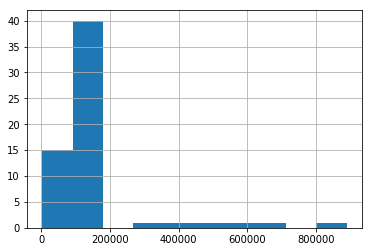

In [24]:
# Investigate patterns in the amount of missing data in each column.
column_missing_values.hist()

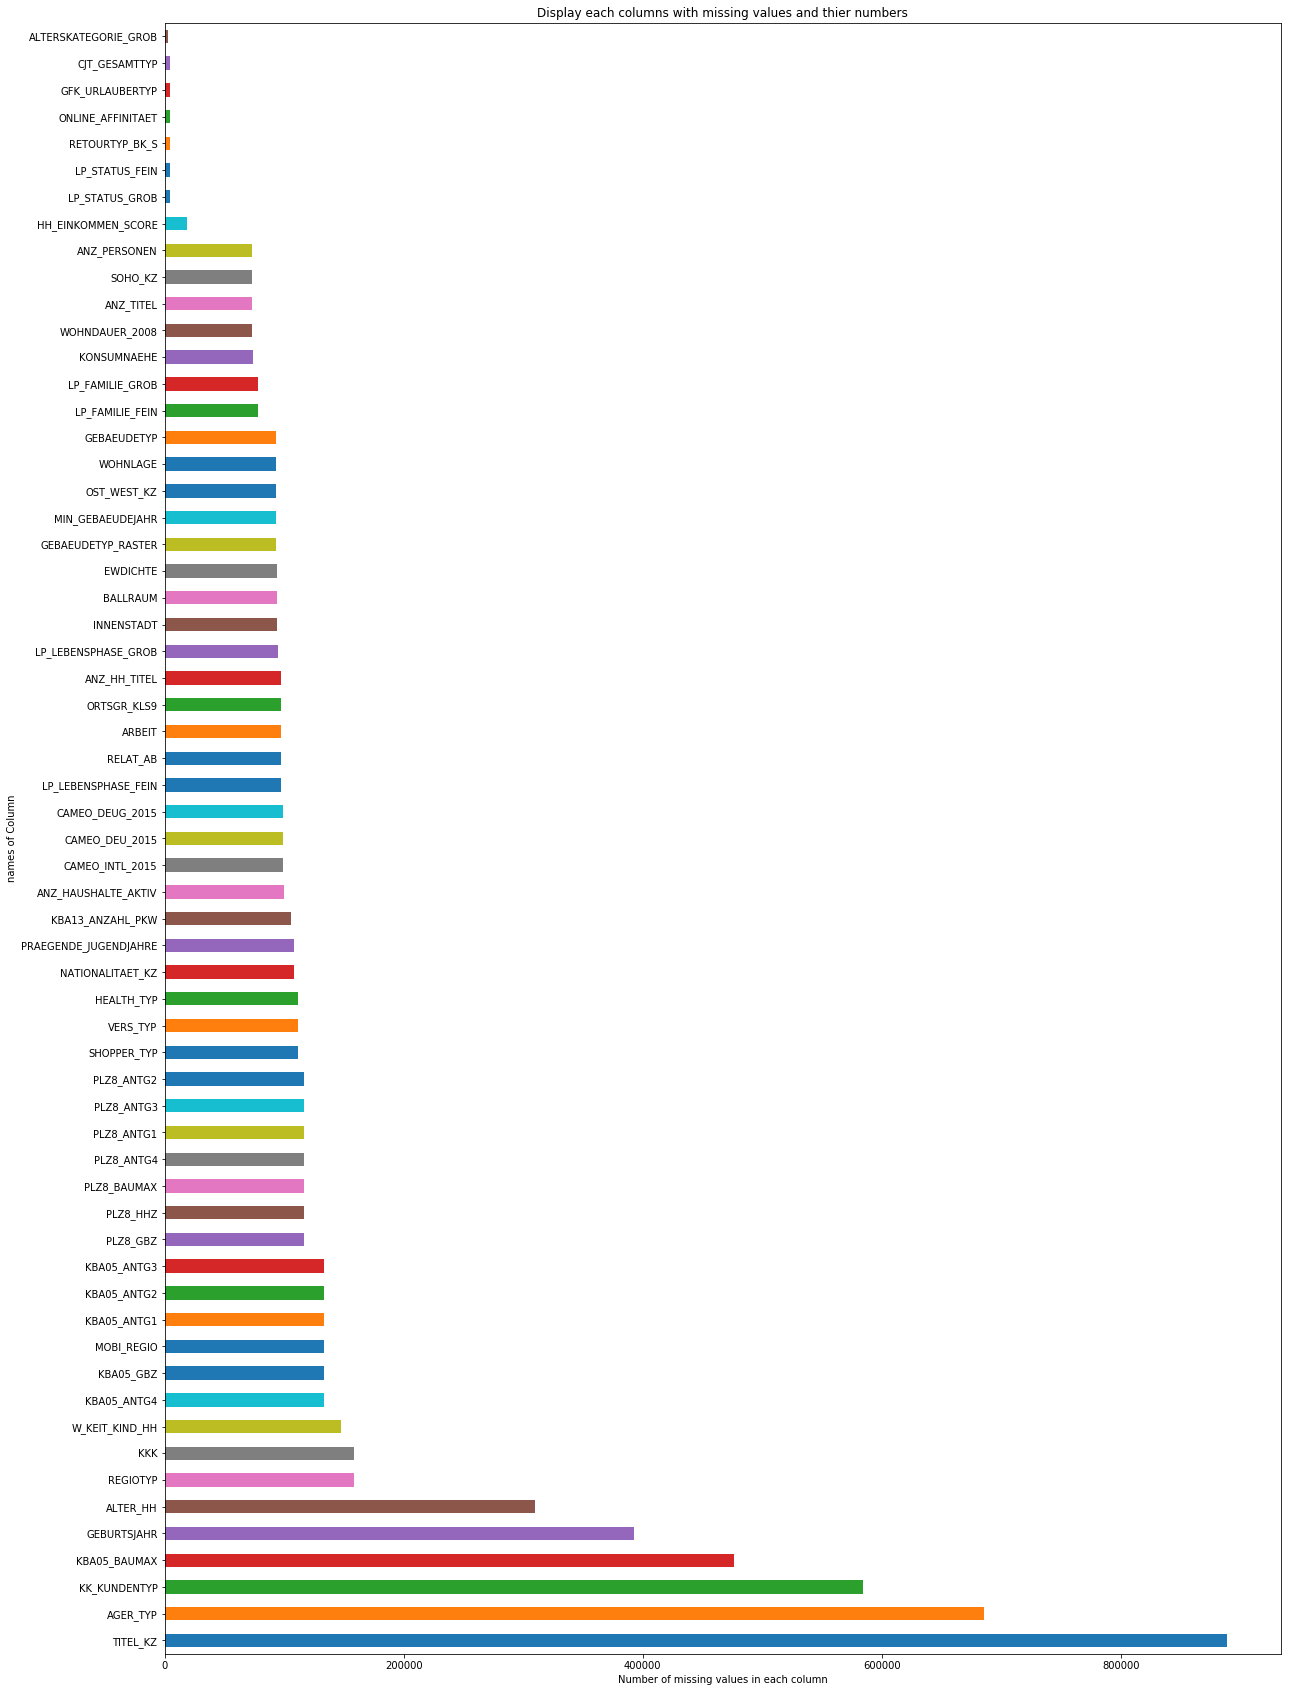

In [25]:
# visualis the columns with missing values in bar chart
column_missing_values.plot.barh(figsize=(20,30))
plt.xlabel('Number of missing values in each column')
plt.ylabel('names of Column')
plt.title('Display each columns with missing values and thier numbers')
plt.show()

In [26]:
# lets calculate the percentage of missing values in each column
percent_missing_per_column =(column_missing_values/len(azdias))*100
percent_missing_per_column

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

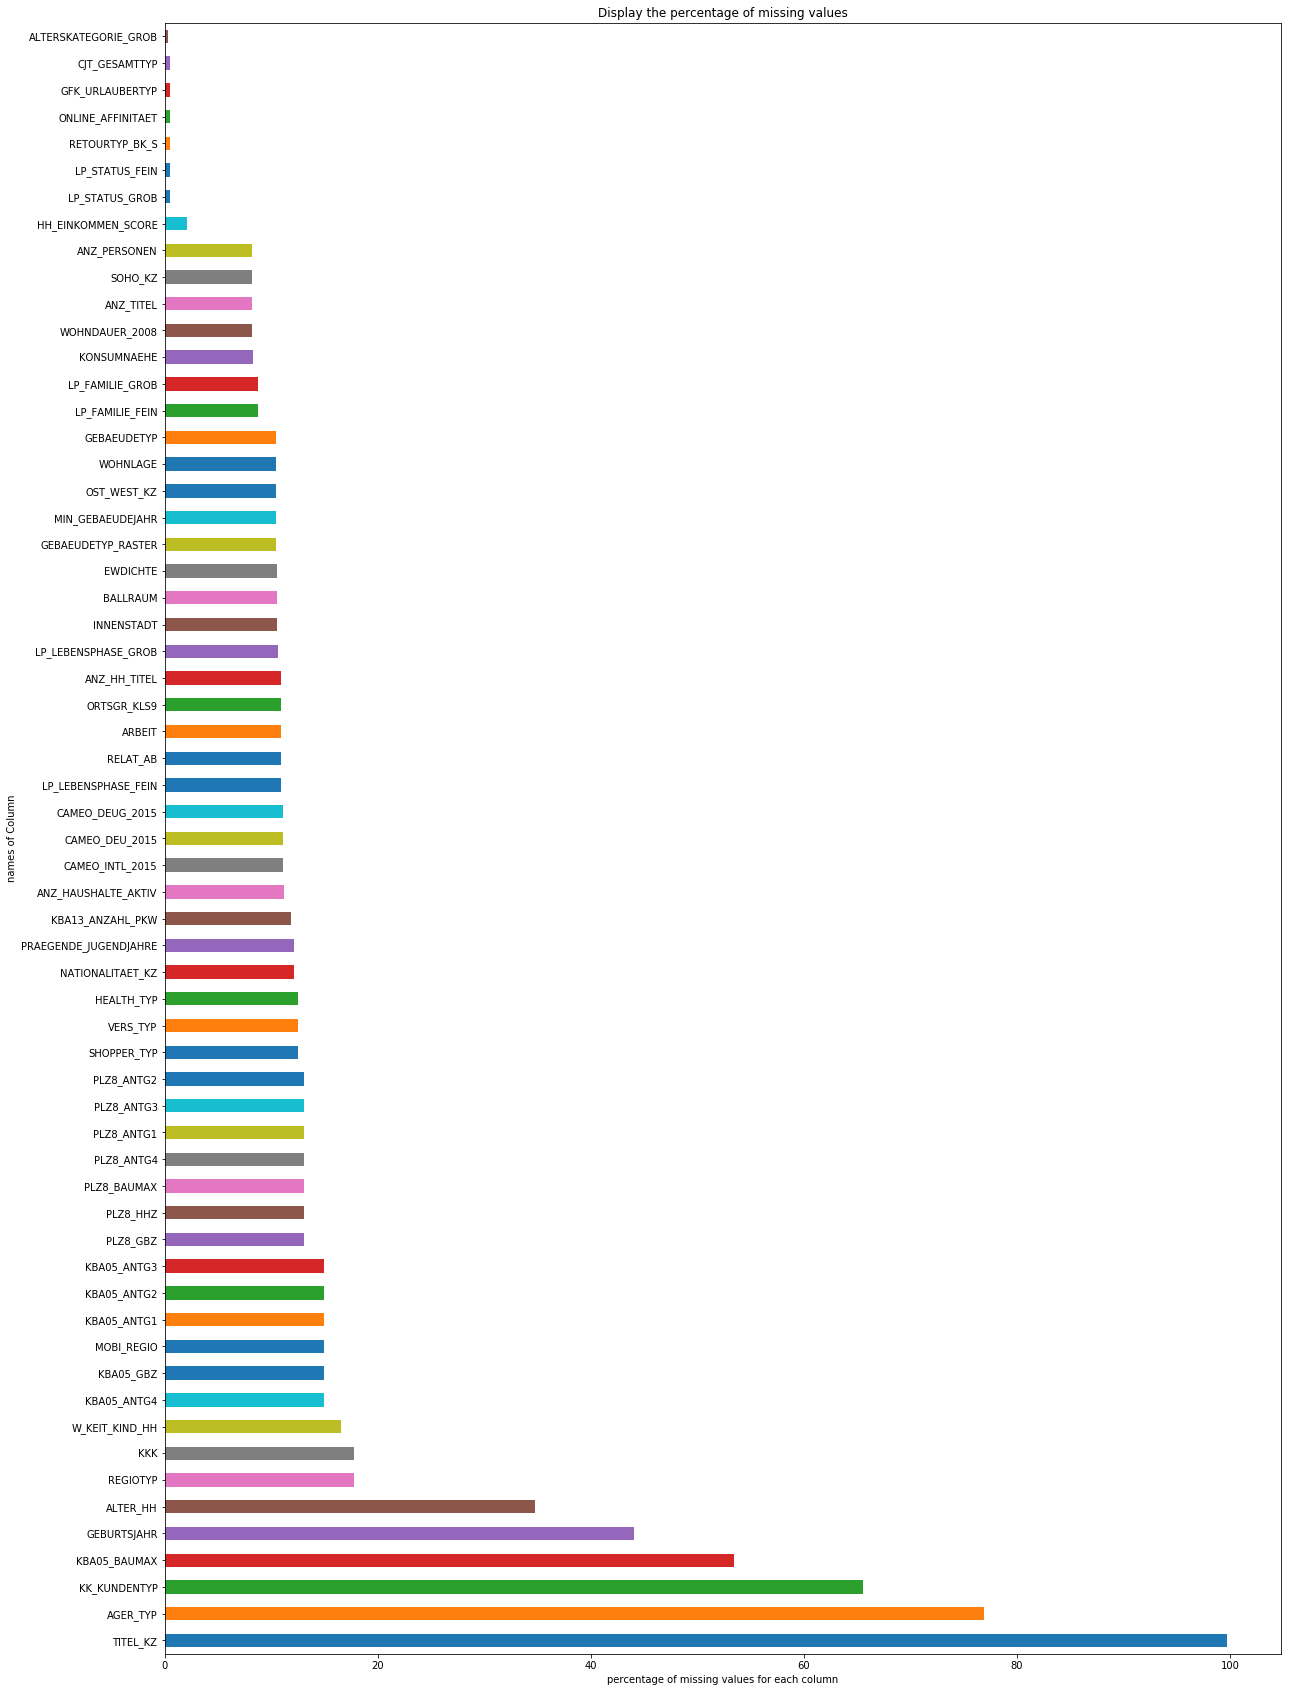

In [27]:
# visualis the columns with missing values in bar chart
percent_missing_per_column.plot.barh(figsize=(20,30))
plt.xlabel('percentage of missing values for each column')
plt.ylabel('names of Column')
plt.title('Display the percentage of missing values')
plt.show()

In [28]:
se_1 = pd.Series(column_missing_values, name='sum of missing data')
se_2 = pd.Series(percent_missing_per_column, name='percent of missing data')

pd.concat([se_1, se_2], axis=1)

,sum of missing data,percent of missing data
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


In [29]:
# Finding names of colums with more than 30  percent missing values 
outlier_columns = percent_missing_per_column[percent_missing_per_column > 30]
outlier_columns

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [30]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = outlier_columns.index
azdias.drop(outlier_columns, axis=1, inplace= True)

In [31]:
print(azdias.shape)
azdias.head()

(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- Regarding the columns with missing data: 
     - There are 6 columns with more than 30% of missing data. which considered as an outlier therefore, These columns were dropped.
     - There is a group of 7 columns having less than 2.06% of missing data.
     - Most of the columns have missing data between 8% - 18%.
- I have notice that the columns with the missing data ratio below 2% are mostly of "personal" - information_level.
- The columns with the missing data ratio between 2% and 11% are related to: 
    - Community and address (which could be potentially filled from other sources) & Personal information about life stage, family size, or estimated household net income (more difficult to fill based on public data).
- The columns with the missing data ratio greater than 11% are various type of "ordinal, categorical, numeric" and cover various information levels. there is no clear patterns observed so far.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [32]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis = 1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [33]:
#select rowa with missing values only
row_missing_values = azdias.isnull().sum(axis = 1)
row_missing_values_only = row_missing_values[row_missing_values > 0] 
row_missing_values_only.sort_values(inplace=True, ascending=False)
row_missing_values_only

732775    49
643174    49
472919    48
604334    47
604314    47
768879    47
604319    47
604322    47
604323    47
275622    47
62901     47
275620    47
604332    47
275617    47
604305    47
275611    47
275610    47
62912     47
604335    47
604338    47
604346    47
604350    47
146293    47
604356    47
62887     47
768892    47
146291    47
348454    47
604091    47
604092    47
          ..
38561      1
768647     1
607245     1
709042     1
507663     1
607271     1
561427     1
235434     1
235435     1
235445     1
607405     1
62924      1
144785     1
91916      1
820005     1
607433     1
709002     1
38612      1
144760     1
561377     1
607469     1
423798     1
423777     1
507723     1
768704     1
736034     1
736038     1
768679     1
736043     1
237075     1
Length: 268012, dtype: int64

In [34]:
row_missing_values_only.describe()

count    268012.000000
mean         18.787607
std          18.320049
min           1.000000
25%           4.000000
50%           8.000000
75%          43.000000
max          49.000000
dtype: float64

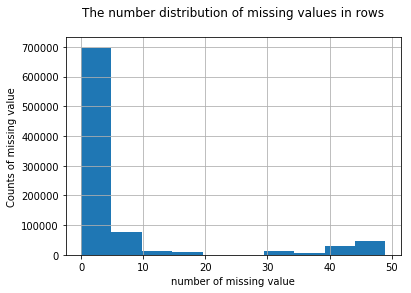

In [35]:
plt.hist(row_missing_values)
plt.xlabel('number of missing value')
plt.ylabel('Counts of missing value')
plt.title('The number distribution of missing values in rows\n')
plt.grid(True)
plt.show()

In [36]:
# calculating the percent of missing values in a row
percent_missing_per_row =(row_missing_values_only/azdias.shape[1])*100
percent_missing_per_row

732775    62.025316
643174    62.025316
472919    60.759494
604334    59.493671
604314    59.493671
768879    59.493671
604319    59.493671
604322    59.493671
604323    59.493671
275622    59.493671
62901     59.493671
275620    59.493671
604332    59.493671
275617    59.493671
604305    59.493671
275611    59.493671
275610    59.493671
62912     59.493671
604335    59.493671
604338    59.493671
604346    59.493671
604350    59.493671
146293    59.493671
604356    59.493671
62887     59.493671
768892    59.493671
146291    59.493671
348454    59.493671
604091    59.493671
604092    59.493671
            ...    
38561      1.265823
768647     1.265823
607245     1.265823
709042     1.265823
507663     1.265823
607271     1.265823
561427     1.265823
235434     1.265823
235435     1.265823
235445     1.265823
607405     1.265823
62924      1.265823
144785     1.265823
91916      1.265823
820005     1.265823
607433     1.265823
709002     1.265823
38612      1.265823
144760     1.265823


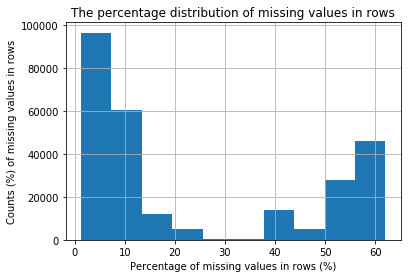

In [37]:
# visualising the histogram of percentage missing row values
plt.hist(percent_missing_per_row)
plt.xlabel('Percentage of missing values in rows (%)')
plt.ylabel('Counts (%) of missing values in rows')
plt.title('The percentage distribution of missing values in rows')
plt.grid(True)
plt.show()

In [38]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
data_missing_below30 = azdias[azdias.isnull().sum(axis=1) < 30]
data_missing_above30 = azdias[azdias.isnull().sum(axis=1) >= 30]

print('Rows with data missing above 30 :', data_missing_above30.shape[0], 'or',np.round(data_missing_above30.shape[0]*100/azdias.shape[0],2), '% of all data')

Rows with data missing above 30 : 93160 or 10.45 % of all data


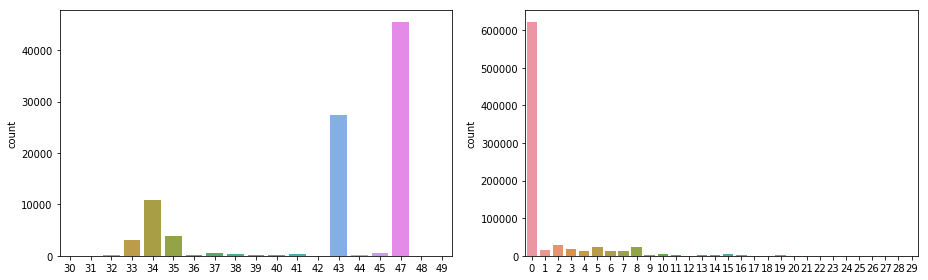

In [39]:
# visulaizing the missing value in each row of the two dataset (above30 & below30)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.countplot(x=data_missing_above30.isnull().sum(axis = 1), data= data_missing_above30,ax=ax1,orient='v')
sns.countplot(x=data_missing_below30.isnull().sum(axis = 1), data= data_missing_below30,ax=ax2,orient='v')
plt.tight_layout()

In [40]:
column_percent_missing = (after_miss_update/azdias.shape[1])*100

In [41]:
#Columns with zero missing data
zero_missing_columns=[]
for i in range(column_percent_missing.shape[0]):
    if(column_percent_missing[i]==0):
        zero_missing_columns.append(column_percent_missing.index[i])
zero_missing_columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [42]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_plot(column_name):
    fig = plt.figure(10, figsize=(12,4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('missing values above 30')
    sns.countplot(data_missing_above30[column_name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('missing values less than 30')
    sns.countplot(data_missing_below30[column_name])
                                                       
    fig.suptitle(column)
    plt.show()

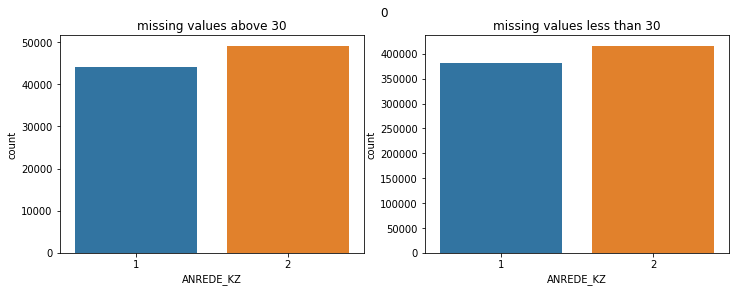

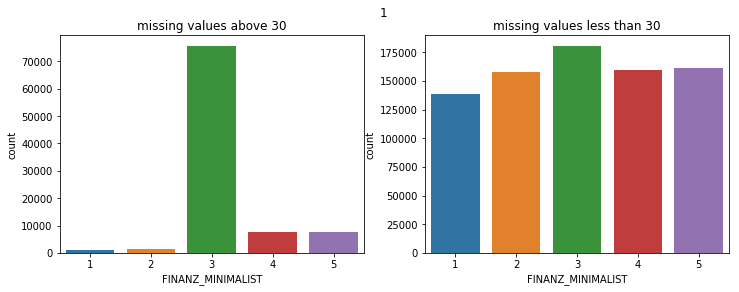

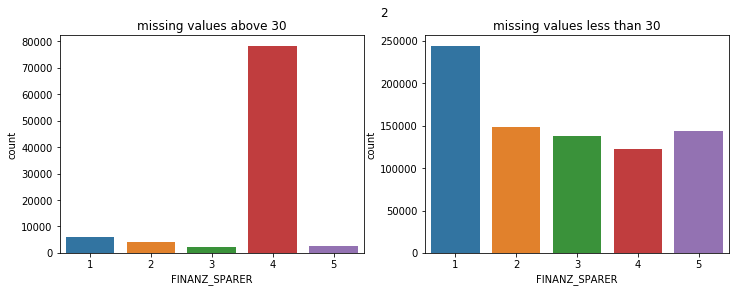

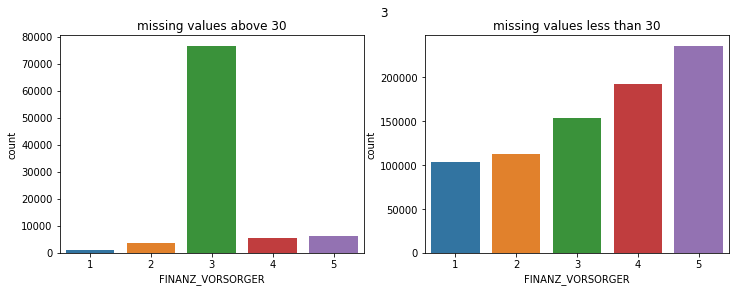

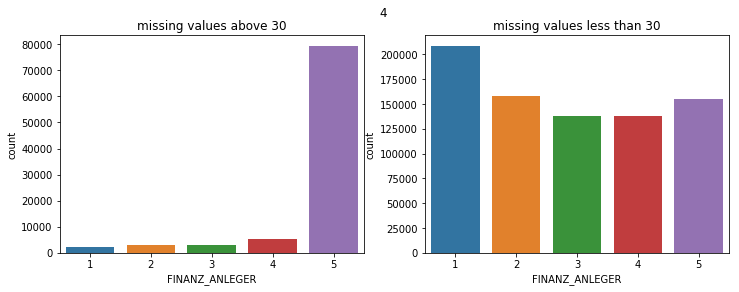

In [43]:
for column in range(5):
    compare_plot(zero_missing_columns[column])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Dataset can be divided into 2 big subsets: missing less or equal to 30 values in a row and missing more than 30 values in a row, We observed that nearly 10% of row data has missing more than 30 values which can be ignored to simplify further processing. We will be going ahead with the dataset having below 30% of missing data, Replacing the nan with using most frequent value in each category.

In [44]:
missing_data_below30 = data_missing_below30.fillna(data_missing_below30.mode().iloc[0])

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [46]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_varibale = feat_info[feat_info.type=='categorical']
categorical_varibale

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [47]:
cat_col= categorical_varibale['attribute'].values
cat_col

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [48]:
cat_col = [cat_col for cat_col in cat_col if cat_col in azdias.columns] 
cat_col

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [52]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary_col = []
multi_col = []
for column in cat_col:
    if azdias[column].nunique() > 2:
        multi_col.append(column)
    else:
        binary_col.append(column)

In [53]:
multi_col

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [54]:
binary_col

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [55]:
# checking unique values in categorical binary column
for col in binary_col:
    print(azdias[col].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [56]:
# converting categorical binary variables with non-numeric values to numeric
azdias.loc[:,'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)

In [57]:
# checking the column values and data types again
for col in binary_col:
    print(azdias[col].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
0    629528
1    168545
Name: OST_WEST_KZ, dtype: int64


In [58]:
# checking unique values in categorical multi column
for col in multi_col:
    print(azdias[col].value_counts())

4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STATUS_FEIN, dtype: int64
1.0    337511
2.0    226915
4.0    162946
5.0    118022
3.0     40973
Na

In [59]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias = pd.get_dummies(azdias, columns=multi_col)

In [60]:
azdias.shape

(891221, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For binary (two-level) categoricals that take numeric values I have kept that as is. For one binary variable (OST_WEST_KZ) I have replaced 'O' as 1 and 'W' as '0' for better semantics. For multi-level categoricals (three or more values), I re encoded it useing OneHotEncoder, Now the feautures have increased to 194 in dataset . I have decided not drop features so not to miss any potential prominent variable.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [61]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [62]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
def movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1

In [63]:
# adding new columns "DECADES"  and 'MOVEMENTS' based on decade of birth and movementrespectively
azdias['DECADES'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(decade)
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [64]:
azdias['DECADES'].value_counts()

6.0    231244
4.0    179558
5.0    151770
3.0    116078
2.0     75646
1.0     28761
Name: DECADES, dtype: int64

In [65]:
azdias['MOVEMENTS'].value_counts()

1.0    607832
0.0    175225
Name: MOVEMENTS, dtype: int64

In [66]:
# Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [67]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [68]:
azdias.CAMEO_INTL_2015.dtype

dtype('O')

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [69]:
# Adding a feature based on wealth
def wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5

# Adding a feature based on life stage
def life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5

In [70]:
# converting to numerics
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

In [71]:
# adding new columns 'WEALTH'  and 'LIFE_STAGE' based on wealth and stage of life respectively
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(life_stage)

In [72]:
azdias['WEALTH'].value_counts()

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: WEALTH, dtype: int64

In [73]:
azdias['LIFE_STAGE'].value_counts()

1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: LIFE_STAGE, dtype: int64

In [74]:
# Dropping 'CAMEO_INTL_2015' column from the dataframe
azdias = azdias.drop('CAMEO_INTL_2015',axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

What I have done here is divided two mixed type features into more features and dropped the original feature columns from the data.
bellow are the steps i have performed above,

- Regarding the column "PRAEGENDE_JUGENDJAHRE" I replaced it with two new columns: "movement" and "decade" according to the mapping from the "Data_Dictionary.md".

- Regarding the column "CAMEO_INTL_2015" I replaced it two new columns: "WEALTH" and "LIFE_STAGE" according to the mapping from the "Data_Dictionary.md" for the logic behind data separation.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',


In [76]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.shape

(891221, 196)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [77]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i,item in zip(range(len(df)), df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',')
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            
            df[column_name] = df[column_name].replace(miss,np.nan)
    
    
    # remove selected columns and rows, ...            
    df = df.drop(outlier_columns,axis=1)
    
    missing_value_rows = df.isnull()
    total_missing_rows = missing_value_rows.sum(axis=1)
    
    cdata_missing_above30 = df[df.isnull().sum(axis=1) >= 30]
    cdata_missing_below30 = df[df.isnull().sum(axis=1) < 30]

    print('Rows with data missing above 30 :', cdata_missing_above30.shape[0], 'or', np.round(cdata_missing_above30.shape[0]*100/df.shape[0],2), '% of all data')
    
    cdata_missing_below30 = cdata_missing_below30.fillna(cdata_missing_below30.mode().iloc[0])
    
    # select, re-encode, and engineer column values.
    cat_varibale = feat_info[feat_info.type=='categorical']
    cat_coloum= categorical_varibale['attribute'].values
    cat_coloum = [cat_coloum for cat_coloum in cat_coloum if cat_coloum in df.columns] 

    binary_categ_clo=[]
    multi_categ_clo=[]

    for column in cat_coloum:
        if df[column].nunique() > 2:
            multi_categ_clo.append(column)
        else:
            binary_categ_clo.append(column)

        # encoding the 'OST_WEST_KZ' binary categorical column
    df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True) 
    # Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df, columns=multi_categ_clo)
    
    # Engineering(converting) "PRAEGENDE_JUGENDJAHRE" and 'CAMEO_INTL_2015'into two new variables each     
    # adding 2 new columns "DECADES" and 'MOVEMENTS' based on decade of birth and movement
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    # Dropping 'PRAEGENDE_JUGENDJAHRE' column from the dataframe
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
        
    # Adding 2 new features based on wealth and life stage and dropping 'CAMEO_INTL_2015'
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # impute NaN 
    col_list = df.columns
    imputer = Imputer(strategy='mean', axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns=col_list)
    
    print('Done')
    
    # Return the cleaned dataframe.
    return df , cdata_missing_below30

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [78]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.isnull().sum().sum()

4556457

In [79]:
# copying azdias
azdias_clean =azdias.copy()
col_list = azdias_clean.columns

In [80]:
imputer = Imputer(strategy='mean', axis=0)

In [81]:
azdias_clean = imputer.fit_transform(azdias_clean)

In [82]:
azdias_clean = pd.DataFrame(azdias_clean, columns= col_list)
azdias_clean.isnull().sum().sum()

0

In [83]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,2.190129,...,0.0,0.0,0.0,0.0,0.0,0.0,4.332805,0.77623,3.262098,2.873033
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,1.00000,5.000000,1.000000
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.00000,2.000000,4.000000
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,1.00000,1.000000,2.000000
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,1.00000,4.000000,3.000000


In [84]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

In [85]:
scaled_azdias = scaler.fit_transform(azdias_clean)

In [86]:
scaled_azdias = pd.DataFrame(scaled_azdias, columns= col_list)
scaled_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,-0.750972,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.000000,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-1.298633e-15,8.525720e-16,3.216984e-16,6.346104e-16
1,-1.742724,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,1.146266,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,1.218829e+00,5.727990e-01,1.258937e+00,-1.338297e+00
2,0.240781,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,1.146266,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,1.218829e+00,-1.986963e+00,-9.142640e-01,8.052265e-01
3,1.232533,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.269102,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.433020e-01,5.727990e-01,-1.638664e+00,-6.237891e-01
4,0.240781,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,1.146266,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.433020e-01,5.727990e-01,5.345367e-01,9.071870e-02


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I replaced all missing values with the mean of the coulmns using the Imputer method.Afterwards, I used the the StandardScaler to scaling the features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [87]:
# Apply PCA to the data.
pca =PCA()

In [88]:
pca_azdias = pca.fit_transform(scaled_azdias)

In [89]:
# Investigate the variance accounted for by each principal component.


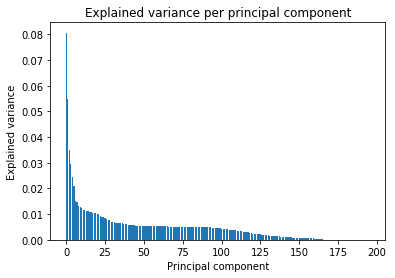

In [90]:
num_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

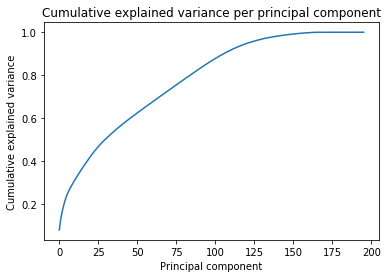

In [91]:
cum_vals = np.cumsum(values)
plt.plot(num_components,cum_vals)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance per principal component")
plt.show()

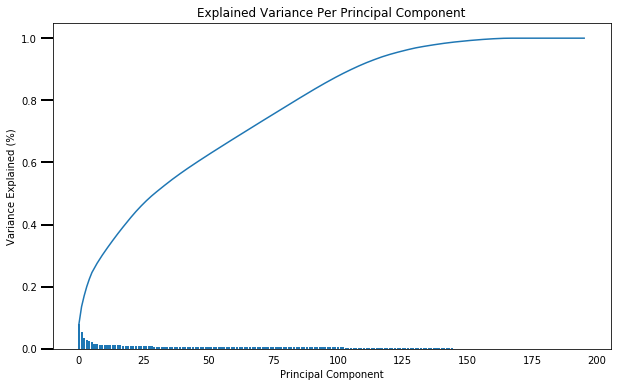

In [92]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
     #   ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [93]:
# Let's see in numbers how variability coverage grows
# when adding more and more components
for i in np.arange(10, 100, 5):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.3014040590989565 of variance.
15 components explain 0.35967964114403017 of variance.
20 components explain 0.412596489995321 of variance.
25 components explain 0.4598949365641065 of variance.
30 components explain 0.4988942087437932 of variance.
35 components explain 0.5324147528988827 of variance.
40 components explain 0.5635880219010524 of variance.
45 components explain 0.5923620135935828 of variance.
50 components explain 0.6197301407153252 of variance.
55 components explain 0.6463545395415847 of variance.
60 components explain 0.6726039798325383 of variance.
65 components explain 0.6986073184529201 of variance.
70 components explain 0.7244593106538693 of variance.
75 components explain 0.7501759311590944 of variance.
80 components explain 0.7758121950036743 of variance.
85 components explain 0.8012962214395284 of variance.
90 components explain 0.8264469868848294 of variance.
95 components explain 0.8507718625877154 of variance.


In [94]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_95 = PCA(n_components= 95)
pca_azdias_2 = pca_95.fit_transform(scaled_azdias)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

There are close to 200 componenets,It seems that with PCA we should be fine reducing the dimensions of our dataset by half,from 200 features to 100 PCA components. This reduction will still allow us to capture almost 85% of data variability.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [95]:
def PCA_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(scaled_azdias.columns)).iloc[i]
    weights = df.sort_values(ascending=False)
    return weights

def plot_pca(data, pca, n):
    compo = pd.DataFrame(np.round(pca.components_, 6), columns = data.keys()).iloc[n-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(7), compo.tail(7)])
    
    compo.plot(kind='bar', title='Component ' + str(n))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

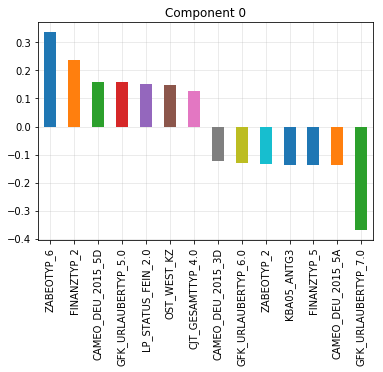

LP_STATUS_GROB_1.0      0.183616
PLZ8_ANTG3              0.183134
WEALTH                  0.182538
PLZ8_ANTG4              0.177852
PLZ8_BAUMAX             0.173622
HH_EINKOMMEN_SCORE      0.161747
ORTSGR_KLS9             0.156865
EWDICHTE                0.155215
FINANZ_HAUSBAUER        0.146701
KBA05_ANTG4             0.126662
PLZ8_ANTG2              0.125354
LP_STATUS_FEIN_1.0      0.125231
ANZ_HAUSHALTE_AKTIV     0.114940
ARBEIT                  0.114135
KBA05_ANTG3             0.112637
CAMEO_DEUG_2015_9       0.110115
RELAT_AB                0.107732
LP_STATUS_FEIN_2.0      0.103559
FINANZTYP_1             0.098368
MOVEMENTS               0.096878
FINANZ_SPARER           0.096559
LP_FAMILIE_FEIN_1.0     0.094953
LP_FAMILIE_GROB_1.0     0.094953
CAMEO_DEUG_2015_8       0.090171
SEMIO_PFLICHT           0.069169
ZABEOTYP_5              0.068588
GEBAEUDETYP_3.0         0.065273
SEMIO_REL               0.061806
CAMEO_DEU_2015_8A       0.061626
REGIOTYP                0.059418
          

In [96]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
plot_pca(scaled_azdias, pca_95, 0)
weights_pc1 = PCA_weights (pca_95,0)
weights_pc1

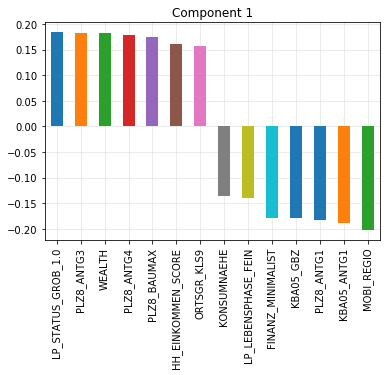

ALTERSKATEGORIE_GROB     0.237916
FINANZ_VORSORGER         0.230452
SEMIO_ERL                0.179391
SEMIO_LUST               0.159433
RETOURTYP_BK_S           0.158931
ZABEOTYP_3               0.158162
W_KEIT_KIND_HH           0.129741
CJT_GESAMTTYP_2.0        0.113317
FINANZ_MINIMALIST        0.110386
FINANZTYP_5              0.108964
FINANZTYP_2              0.105209
NATIONALITAET_KZ_1.0     0.096215
LP_STATUS_FEIN_1.0       0.092483
SHOPPER_TYP_3.0          0.079786
FINANZTYP_6              0.079652
CJT_GESAMTTYP_1.0        0.076372
FINANZ_HAUSBAUER         0.071501
LP_FAMILIE_GROB_1.0      0.068859
LP_FAMILIE_FEIN_1.0      0.068859
GFK_URLAUBERTYP_4.0      0.061851
WOHNDAUER_2008           0.057978
EWDICHTE                 0.053423
LP_STATUS_FEIN_3.0       0.053167
ORTSGR_KLS9              0.052456
PLZ8_ANTG3               0.051583
PLZ8_ANTG4               0.048650
GFK_URLAUBERTYP_7.0      0.048482
HH_EINKOMMEN_SCORE       0.046310
PLZ8_BAUMAX              0.045493
LP_FAMILIE_GRO

In [97]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(scaled_azdias, pca_95, 1)
weights_pc2= PCA_weights (pca_95,1)
weights_pc2

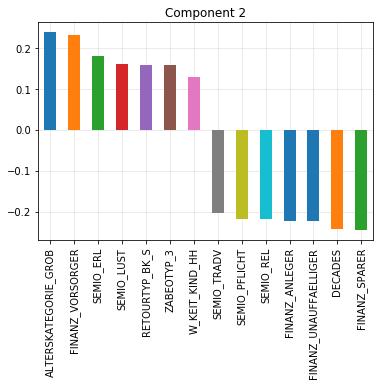

SEMIO_VERT               0.325962
SEMIO_KULT               0.280085
SEMIO_SOZ                0.277642
SEMIO_FAM                0.207070
SHOPPER_TYP_0.0          0.137376
ZABEOTYP_1               0.131799
FINANZTYP_5              0.112884
FINANZ_MINIMALIST        0.101505
NATIONALITAET_KZ_1.0     0.088299
GREEN_AVANTGARDE         0.085802
SHOPPER_TYP_1.0          0.083436
SEMIO_MAT                0.076325
SEMIO_REL                0.062590
LP_STATUS_GROB_5.0       0.059561
LP_STATUS_FEIN_10.0      0.059561
ZABEOTYP_6               0.055872
ORTSGR_KLS9              0.049575
EWDICHTE                 0.047865
CJT_GESAMTTYP_4.0        0.047375
LP_STATUS_FEIN_1.0       0.046391
NATIONALITAET_KZ_2.0     0.045653
GEBAEUDETYP_3.0          0.043475
SEMIO_TRADV              0.043336
FINANZTYP_3              0.043319
RETOURTYP_BK_S           0.042805
PLZ8_BAUMAX              0.042196
CAMEO_DEUG_2015_9        0.040919
PLZ8_ANTG4               0.039581
LP_FAMILIE_GROB_5.0      0.039297
ONLINE_AFFINIT

In [98]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(scaled_azdias, pca_95,2)
weights_pc3= PCA_weights (pca_95,2)
weights_pc3

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

We can interpret some relationships between negative and positive weights and positive values together or negative values together. For example, in the 1st principle component 'PLZ8_ANTG3' with positive weight as opposed 'FINANZTYP_2' with negative weight. if 'PLZ8_ANTG3' goes up , the 'FINANZTYP_2' goes down. The same goes for 2nd and 3rd principle component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [99]:
def get_Kmean_score(data, n_cluster):
    #instantiate kmeans
    kmeans = KMeans(n_clusters = n_cluster)
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [100]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
centers = list(range(10,25))
for c in centers:
    scores.append(get_Kmean_score(pca_azdias_2, c))
    print(c)

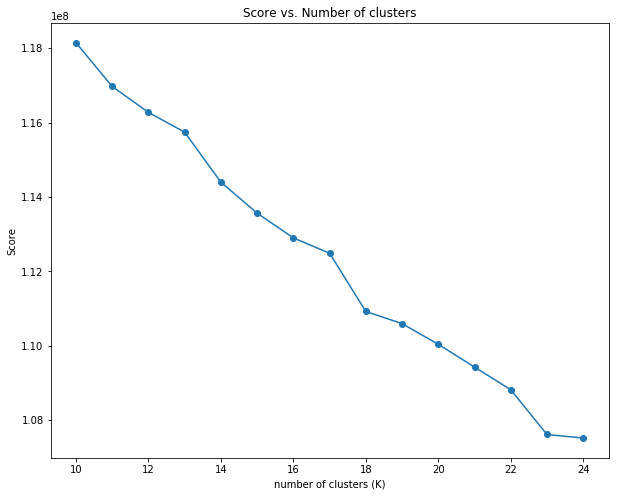

In [101]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 8))
plt.plot(centers, scores, linestyle='-', marker='o')
plt.xlabel('number of clusters (K)')
plt.ylabel('Score')
plt.title('Score vs. Number of clusters');

In [102]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 18)
model = kmeans.fit(pca_azdias_2)
azdias_pred = model.predict(pca_azdias_2)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I used sklearn's KMeans class to perform k-means clustering on the PCA-transformed data, I tried to use the elbow method but as we saw in the plot we can't see the elbow but we can see the score decreases with the number of clusters increase between 18-24 clusters so I decided to choose 18 clusters .

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [103]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [104]:
customers.shape

(191652, 85)

In [105]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean, customer_many_missing  = clean_data(customers)

Rows with data missing above 30 : 49927 or 26.05 % of all data
Done


In [106]:
print(customers_clean.shape)
customers_clean.head()

(191652, 195)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.000000,1.000000,3.00000
1,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.886124,0.508476,2.598761,3.36817
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.000000,3.000000,4.00000
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,2.000000,4.00000
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,1.000000,4.000000,1.00000


In [107]:
list(set(azdias.columns) - set(customers_clean))

['GEBAEUDETYP_5.0']

In [108]:
customers_clean["GEBAEUDETYP_5.0"]=0

In [109]:
list(set(azdias.columns) - set(customers_clean))

[]

In [110]:
customers_clean.isnull().sum().sum()

0

In [111]:
# Apply feature scaling
#scaler = StandardScaler()
scaled_customers = scaler.fit_transform(customers_clean)
scaled_customers = pd.DataFrame(scaled_customers, columns= customers_clean.columns.tolist())
scaled_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
0,0.888186,-0.776965,1.000000,-0.801149,0.820488,-0.847979,-0.407296,-0.680853,1.312832,-1.428163,...,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-7.615129e-01,-1.176796,-1.326399e+00,-3.201484e-01,0.0
1,0.888186,-0.776965,1.000000,-0.801149,0.820488,-0.847979,0.223021,-0.680853,-0.761712,-1.428163,...,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,3.816390e-16,0.000000,7.368700e-16,1.158497e-15,0.0
2,0.888186,1.287059,1.000000,-0.801149,0.820488,-0.847979,0.853339,1.062295,1.312832,0.069926,...,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-7.615129e-01,-1.176796,3.328846e-01,5.494193e-01,0.0
3,0.888186,-0.776965,1.000000,-0.801149,0.820488,-0.259026,-1.037614,-0.680853,-0.761712,0.069926,...,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-1.620888e+00,1.137562,-4.967573e-01,5.494193e-01,0.0
4,-0.050165,-0.776965,-0.930079,-0.801149,-0.184171,0.918880,1.483656,-0.680853,-0.761712,1.568014,...,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,9.572365e-01,1.137562,1.162526e+00,-2.059284e+00,0.0


In [112]:
# PCA transformation
customers_pca = pca_95.transform(scaled_customers)

In [115]:
#predict clustering using the kmeans object
customers_pred = KMeans(n_clusters=19).fit_predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

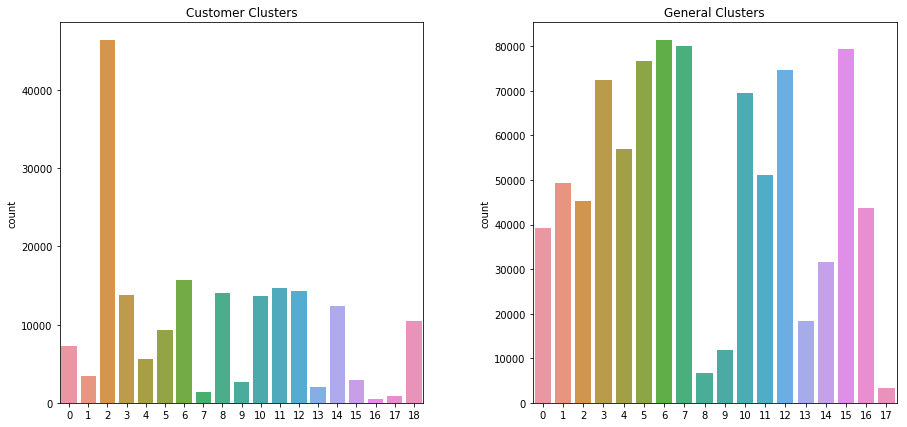

In [143]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,7))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [117]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_2 = scaler.inverse_transform(pca_95.inverse_transform(model.cluster_centers_[2]))


In [119]:
overrepresented_c = pd.Series(data = centroid_2, index = customers_clean.columns)
overrepresented_c

ALTERSKATEGORIE_GROB      3.818841
ANREDE_KZ                 1.577660
FINANZ_MINIMALIST         3.853845
FINANZ_SPARER             1.263174
FINANZ_VORSORGER          4.716074
FINANZ_ANLEGER            2.305297
FINANZ_UNAUFFAELLIGER     1.496203
FINANZ_HAUSBAUER          3.494351
GREEN_AVANTGARDE          0.164825
HEALTH_TYP                1.826010
LP_LEBENSPHASE_FEIN      20.512652
LP_LEBENSPHASE_GROB       5.748885
RETOURTYP_BK_S            4.059058
SEMIO_SOZ                 3.127280
SEMIO_FAM                 3.213918
SEMIO_REL                 2.426081
SEMIO_MAT                 3.036791
SEMIO_VERT                3.865716
SEMIO_LUST                5.931050
SEMIO_ERL                 5.819075
SEMIO_KULT                2.661092
SEMIO_RAT                 2.608396
SEMIO_KRIT                5.231171
SEMIO_DOM                 4.357508
SEMIO_KAEM                4.260815
SEMIO_PFLICHT             2.527024
SEMIO_TRADV               2.247436
SOHO_KZ                   0.007272
VERS_TYP            

In [121]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_16 = scaler.inverse_transform(pca_95.inverse_transform(model.cluster_centers_[16]))


In [122]:
underrepresented_c = pd.Series(data = centroid_16, index = customers_clean.columns)
underrepresented_c

ALTERSKATEGORIE_GROB      3.468780
ANREDE_KZ                 1.346036
FINANZ_MINIMALIST         4.958434
FINANZ_SPARER             1.383668
FINANZ_VORSORGER          4.517421
FINANZ_ANLEGER            2.214465
FINANZ_UNAUFFAELLIGER     1.904372
FINANZ_HAUSBAUER          1.858564
GREEN_AVANTGARDE          0.148473
HEALTH_TYP                1.899564
LP_LEBENSPHASE_FEIN      42.192899
LP_LEBENSPHASE_GROB      13.379861
RETOURTYP_BK_S            3.662924
SEMIO_SOZ                 3.667164
SEMIO_FAM                 3.867702
SEMIO_REL                 3.216865
SEMIO_MAT                 3.289463
SEMIO_VERT                4.869218
SEMIO_LUST                5.592570
SEMIO_ERL                 4.997714
SEMIO_KULT                3.552173
SEMIO_RAT                 2.817021
SEMIO_KRIT                4.048722
SEMIO_DOM                 4.149172
SEMIO_KAEM                3.816719
SEMIO_PFLICHT             3.015281
SEMIO_TRADV               2.631637
SOHO_KZ                   0.012174
VERS_TYP            

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

By looking at the graph we can easily find that the cluster points 2, 6 and 11 data points are highly likely customer segments because the larger praportion of customer data is present at these points while data points that are defined by cluster points 16, 17 and 7 are less likely to be turned into customers are general population data dominates these clusters.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.